# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, date

# Load Data
* Handle missing values, duplicated values, outlier

In [3]:
total = pd.read_csv("https://raw.githubusercontent.com/lavibula/ML20222.PredictionBitcoin/main/working/Data_working.csv")
#cac gia tri row > 4658 duoc xoa -> NULL
total = total.loc[:4658,:] 
#dien cac gia tri con thieu
total = total.fillna(method='ffill')
for index in total.index:
  total.loc[index, "Date"] = datetime.strptime(str(total.loc[index, "Date"])[:10], '%d/%m/%Y').date()
print(total.head())


         Date  BTC_close  BTC_open  BTC_high  BTC_low  BTC_volume   
0  2023-04-16    30310.3   30299.2   30545.3  30134.6       34.48  \
1  2023-04-15    30299.6   30472.6   30586.5  30208.8       31.71   
2  2023-04-14    30472.5   30387.4   30964.9  30026.0       98.38   
3  2023-04-13    30387.4   29892.4   30524.1  29864.5       65.87   
4  2023-04-12    29886.4   30209.8   30473.0  29679.5       78.69   

   Active_Addr_Cnt    Difficulty  Mean_Block_Size(in_bytes)  Sum_Block_Weight   
0         840992.0  4.788780e+13                1866594.290       495223185.0  \
1        1045660.0  4.788780e+13                1839875.354       631025193.0   
2        1016042.0  4.788780e+13                1759535.436       559166432.0   
3        1009669.0  4.788780e+13                1812112.549       567094231.0   
4        1056542.0  4.788780e+13                1933495.919       635037442.0   

   ...      ETH     LTC      DOGE      XRP    GOLD  SILVER  COPPER   S&P500   
0  ...  2119.29  10

# Slpit Data (Testing, Training Data Sets)

In [4]:
#ETH ra doi ngay 30/7/2015, random 1 date sau do
#Biểu đồ giá đóng cửa Bitcoin (BTC) cho thấy một mô hình tương đối bằng phẳng trong dữ liệu từ tháng 9 năm 2014 đến tháng 7 năm 2016, 
#sau đó là đợt tăng giá mạnh từ tháng 9 năm 2017 đến tháng 1 năm 2018
Start_day = date(2015, 9, 1)
Test_day = date(2018,6,30)
#chon ra 20-25% data trong giai doan 1
End_day = date(2018,9,30)
# train, test
total = total[(total["Date"] >= Start_day) & (total["Date"] <= End_day) ].reset_index(drop = True)
train_dataset = total[total["Date"] < Test_day].reset_index(drop = True)
test_dataset = total[total["Date"] >= Test_day].reset_index(drop = True)
print(test_dataset.head())
print(test_dataset.tail())

         Date  BTC_close  BTC_open  BTC_high  BTC_low  BTC_volume   
0  2018-09-30     6635.2    6603.9    6673.9   6533.5        9.34  \
1  2018-09-29     6603.9    6633.9    6648.4   6464.4        9.42   
2  2018-09-28     6636.0    6685.7    6809.2   6538.6        9.57   
3  2018-09-27     6689.2    6463.7    6738.3   6428.8        9.34   
4  2018-09-26     6468.1    6443.0    6551.9   6384.1        8.64   

   Active_Addr_Cnt    Difficulty  Mean_Block_Size(in_bytes)  Sum_Block_Weight   
0         514766.0  7.152630e+12                610653.1472       330287157.0  \
1         564628.0  7.152630e+12                709309.6184       355787307.0   
2         654875.0  7.152630e+12                835734.5195       422560874.0   
3         642476.0  7.152630e+12                887769.7133       414744804.0   
4         624467.0  7.152630e+12                894936.2086       406826648.0   

   ...     ETH     LTC      DOGE      XRP    GOLD  SILVER   COPPER   S&P500   
0  ...  232.80  61.

In [5]:
X_train = train_dataset.drop(["Date"], axis=1)[:-1]
Y_train = train_dataset["BTC_close"][1:]

X_test = test_dataset.drop(["Date"], axis=1)[:-1]
Y_test = test_dataset["BTC_close"][1:]

# Load Model

In [6]:
#import sklearn modules
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

In [7]:
simpleTree = RandomForestRegressor(max_depth=15, n_estimators=500)
#Xây dựng cây hồi quy với độ sâu cây là 10 (Random forest), 500 cây
simpleTree.fit(X_train, Y_train)

RandomForestRegressor(max_depth=15, n_estimators=500)

# Graph Predicted Values with Training Set

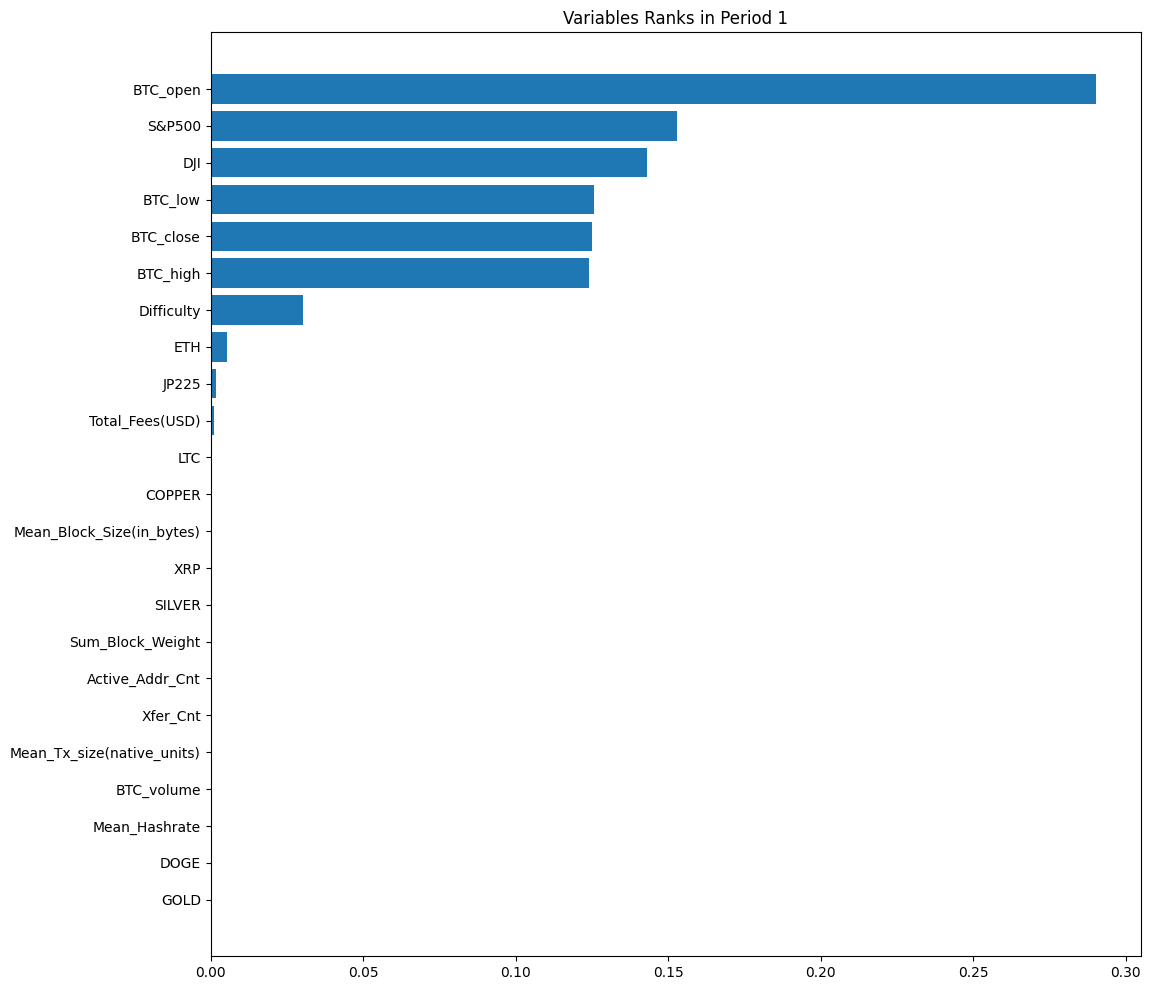

In [8]:
# Importance of variables
features = X_train.columns
importances = simpleTree.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12,12))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), features[indices])
plt.title("Variables Ranks in Period 1")
plt.show()

In [9]:
total_without_date = total.drop('Date', axis=1)
#total_without_date 

In [10]:
#total_without_date.corr()

<Axes: >

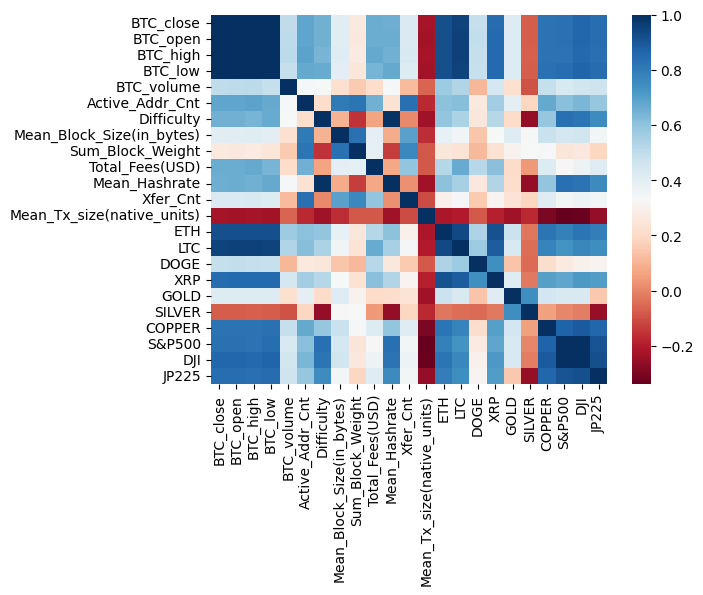

In [11]:
import seaborn as sns
#sns.heatmap(total_without_date.corr(), cmap="viridis")
#sns.heatmap(total_without_date.corr(), cmap="plasma")
#sns.heatmap(total_without_date.corr(), cmap="inferno")
#sns.heatmap(total_without_date.corr(), cmap="magma")
#sns.heatmap(total_without_date.corr(), cmap="cividis")
sns.heatmap(total_without_date.corr(), cmap="RdBu")
#sns.heatmap(total_without_date.corr(), cmap="YlGnBu")
#sns.heatmap(total_without_date.corr(), cmap="YlOrBr")



# Graph Predicted Values with Test Set

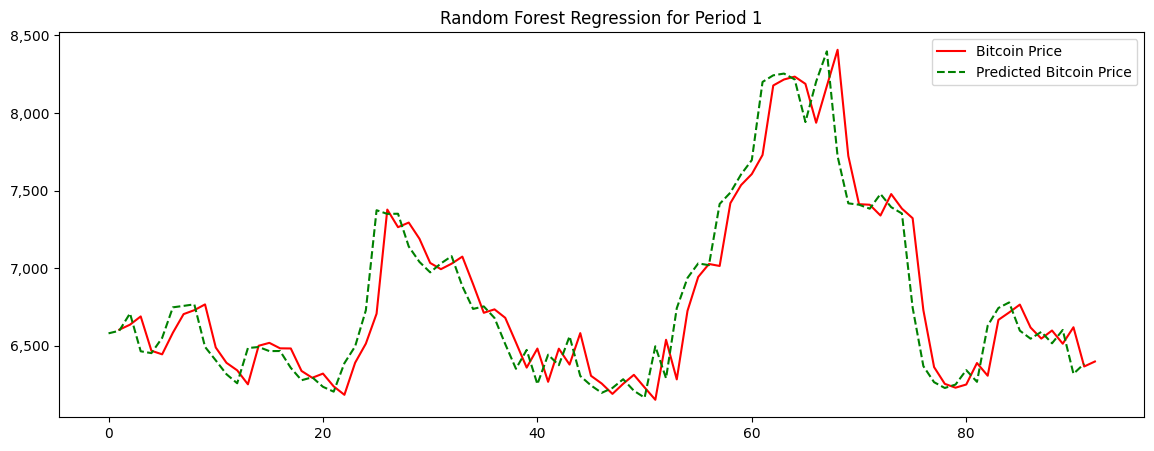

In [12]:
#so sanh cac gia tri du doan va quan sat
Y_pred = simpleTree.predict(X_test)
#hien thi ket qua du doan
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.plot(Y_test, color = 'red', label="Bitcoin Price")
ax.plot(Y_pred, color = 'green', label="Predicted Bitcoin Price", linestyle="dashed")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))  # .3f
plt.title("Random Forest Regression for Period 1")
plt.legend()
plt.show()

# Visualising the results

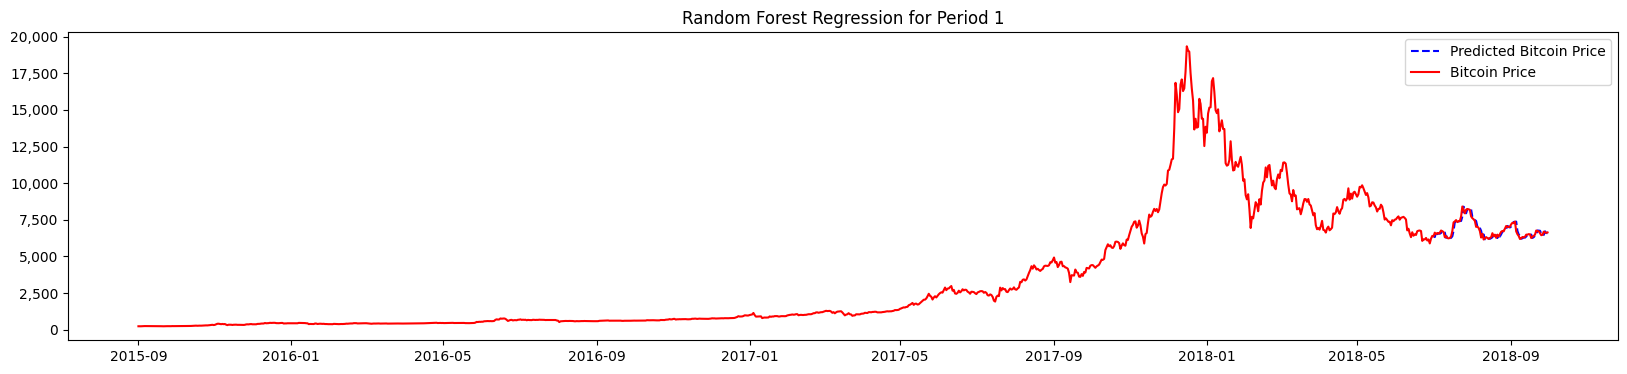

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
ax.plot(total['Date'][:len(Y_pred)], Y_pred, color='blue', label="Predicted Bitcoin Price", linestyle="dashed")
ax.plot(total['Date'], total['BTC_close'], color='red', label="Bitcoin Price")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))  # .3f
plt.title("Random Forest Regression for Period 1")
plt.legend()
plt.show()


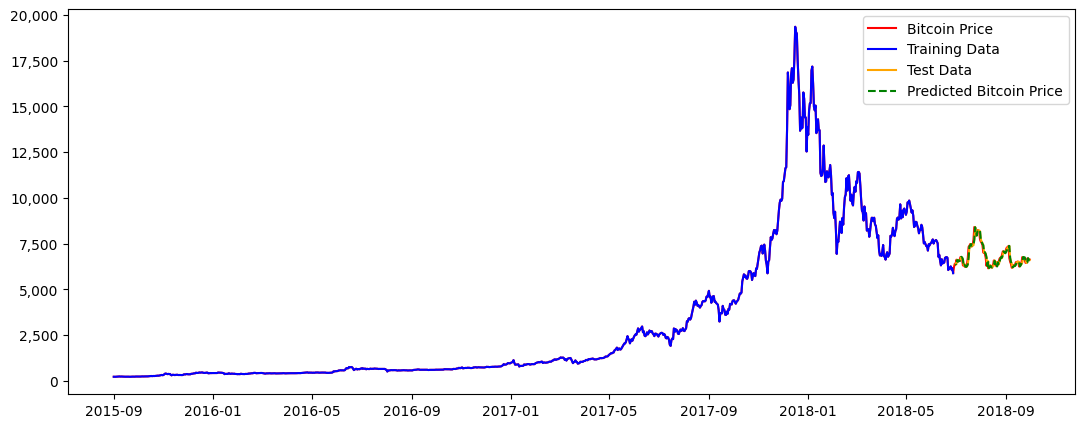

In [14]:
fig, ax = plt.subplots(figsize=(13, 5))

ax.plot(total['Date'], total['BTC_close'], color='red', label="Bitcoin Price")
ax.plot(total['Date'][-len(Y_train):], Y_train, color='blue', label="Training Data")
ax.plot(total['Date'][:len(Y_test)], Y_test, color='orange', label="Test Data")
ax.plot(total['Date'][:len(Y_pred)], Y_pred, color='green', label="Predicted Bitcoin Price", linestyle="dashed")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))) # Định dạng đường trục y
plt.legend()
plt.show()


# Evaluation metrics RMSE, MAPE, DA

In [15]:
#tinh toan loi du doan
#RMSE
from sklearn.metrics import mean_squared_error
print("RMSE:", np.sqrt(mean_squared_error(Y_test, Y_pred)))
print()

#MAPE
MAPE = np.average(np.abs((Y_test.values - Y_pred) / Y_test.values))
print("MAPE:", MAPE)
print()

#DA
Y_test_DA = np.array(Y_test)
Y_pred_0 = Y_pred[1:] - Y_test_DA[:-1]
Y_test_0 = Y_test[1:] - Y_test_DA[:-1]
DA = (Y_pred_0<0) == (Y_test_0<0)
print("DA accuracy:", f"{round(np.mean(DA)*100, 2)}%")

RMSE: 23.853243760363355

MAPE: 0.002660515158265446

DA accuracy: 97.8%


In [16]:
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

start_time = time.time()
features = X_train.columns
importances = simpleTree.feature_importances_
indices = np.argsort(importances)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


Elapsed time to compute the importances: 0.047 seconds


Remove some features of importance 


In [17]:
X1 = train_dataset.loc[:, 'BTC_close':'BTC_low']
X2 = train_dataset.loc[:, 'ETH':'XRP']
X3 = train_dataset.loc[:, 'COPPER':'JP225']

Xtrain = pd.concat([X1, X2, X3], axis=1)
Xtrain



,BTC_close,BTC_open,BTC_high,BTC_low,ETH,LTC,DOGE,XRP,COPPER,S&P500,DJI,JP225
0,6213.3,5883.2,6284.9,5818.5,435.37,79.015,0.002414,0.45531,6620.00,2718.37,24271.41,22304.51
1,5883.5,6154.9,6178.4,5854.0,421.27,74.326,0.002321,0.44786,6625.75,2716.31,24216.05,22270.39
2,6154.9,6081.1,6187.3,6025.4,442.16,80.783,0.002468,0.47186,6695.50,2699.63,24117.59,22271.77
3,6082.1,6256.9,6267.7,6060.0,430.33,75.843,0.002450,0.45304,6727.00,2723.06,24283.11,22342.00
4,6256.6,6155.1,6331.2,6101.7,458.76,81.491,0.002539,0.48080,6704.50,2717.07,24252.80,22338.15
...,...,...,...,...,...,...,...,...,...,...,...,...
1028,233.7,230.3,235.6,228.3,11.75,3.840,0.003213,0.00800,5135.00,1969.41,16492.68,17860.47
1029,230.3,226.2,231.1,225.8,11.75,3.840,0.003213,0.00954,5105.00,1921.22,16102.38,17792.16
1030,226.2,228.6,229.6,225.4,11.75,3.840,0.003213,0.00954,5220.00,1951.13,16374.76,18182.39
1031,228.6,227.2,230.6,225.6,11.75,3.840,0.003213,0.00871,5115.00,1948.86,16351.38,18095.40


In [18]:
X1 = test_dataset.loc[:, 'BTC_close':'BTC_low']
X2 = test_dataset.loc[:, 'ETH':'XRP']
X3 = test_dataset.loc[:, 'COPPER':'JP225']

Xtest = pd.concat([X1, X2, X3], axis=1)
Xtest


,BTC_close,BTC_open,BTC_high,BTC_low,ETH,LTC,DOGE,XRP,COPPER,S&P500,DJI,JP225
0,6635.2,6603.9,6673.9,6533.5,232.80,61.224,0.005933,0.58274,6238.25,2924.59,26651.21,24245.76
1,6603.9,6633.9,6648.4,6464.4,231.87,61.703,0.005887,0.56983,6238.25,2924.59,26651.21,24245.76
2,6636.0,6685.7,6809.2,6538.6,221.77,61.947,0.005894,0.53969,6258.75,2913.98,26458.31,24120.04
3,6689.2,6463.7,6738.3,6428.8,229.15,63.267,0.005890,0.54315,6178.25,2914.00,26439.93,23796.74
4,6468.1,6443.0,6551.9,6384.1,214.35,57.259,0.005776,0.51257,6288.75,2905.97,26385.28,24033.79
...,...,...,...,...,...,...,...,...,...,...,...,...
88,6598.4,6513.8,6774.5,6442.3,467.52,85.360,0.002688,0.49194,6400.75,2736.61,24356.74,21717.04
89,6513.5,6618.6,6676.6,6513.5,461.89,84.919,0.002655,0.48516,6511.00,2713.22,24174.82,21785.54
90,6619.5,6349.1,6680.0,6275.0,475.70,85.462,0.002735,0.49005,6569.00,2726.71,24307.18,21811.93
91,6366.8,6398.5,6445.1,6284.7,452.57,80.042,0.002536,0.46226,6569.00,2726.71,24307.18,21811.93


In [19]:
import numpy as np
from sklearn.impute import KNNImputer
imputer_train = KNNImputer(n_neighbors=10, weights="uniform")
imputer_train.fit_transform(Xtrain)

array([[ 6213.3 ,  5883.2 ,  6284.9 , ...,  2718.37, 24271.41, 22304.51],
       [ 5883.5 ,  6154.9 ,  6178.4 , ...,  2716.31, 24216.05, 22270.39],
       [ 6154.9 ,  6081.1 ,  6187.3 , ...,  2699.63, 24117.59, 22271.77],
       ...,
       [  226.2 ,   228.6 ,   229.6 , ...,  1951.13, 16374.76, 18182.39],
       [  228.6 ,   227.2 ,   230.6 , ...,  1948.86, 16351.38, 18095.4 ],
       [  227.2 ,   229.5 ,   231.4 , ...,  1913.85, 16058.35, 18165.69]])

# Visualising the Results when Removing some Importance Features

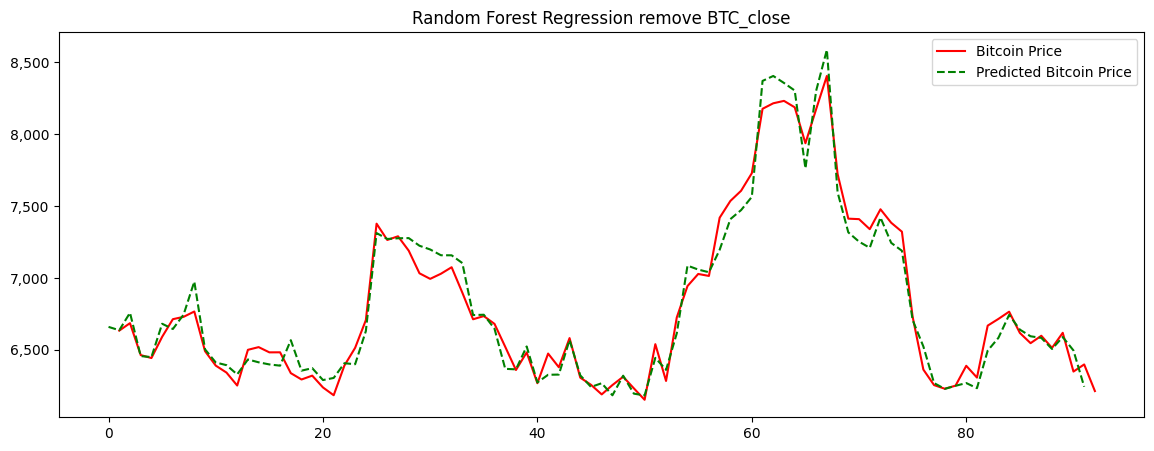

RMSE: 235.94571784852593

MAPE: 0.025114710104754648

DA accuracy: 52.75%


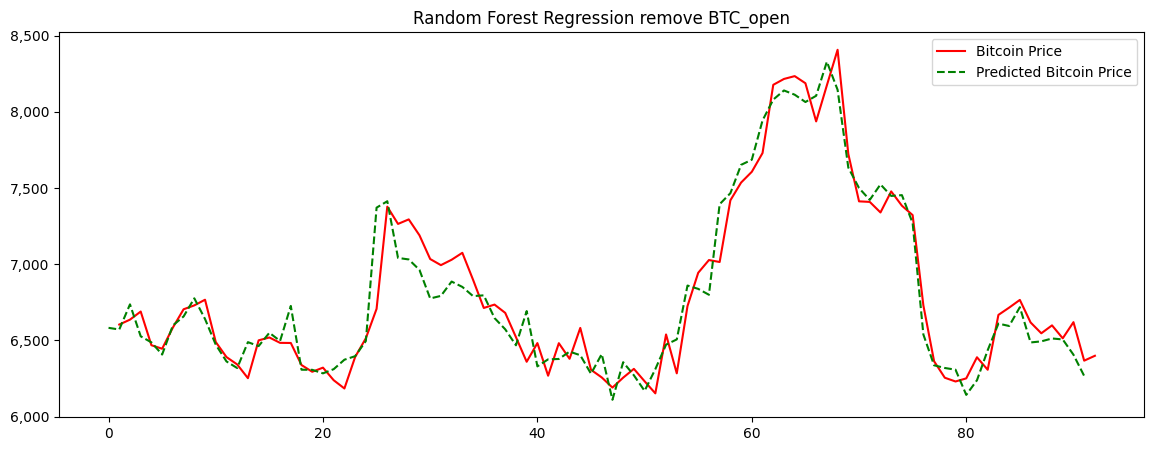

RMSE: 145.54920089307595

MAPE: 0.016381759691109842

DA accuracy: 68.13%


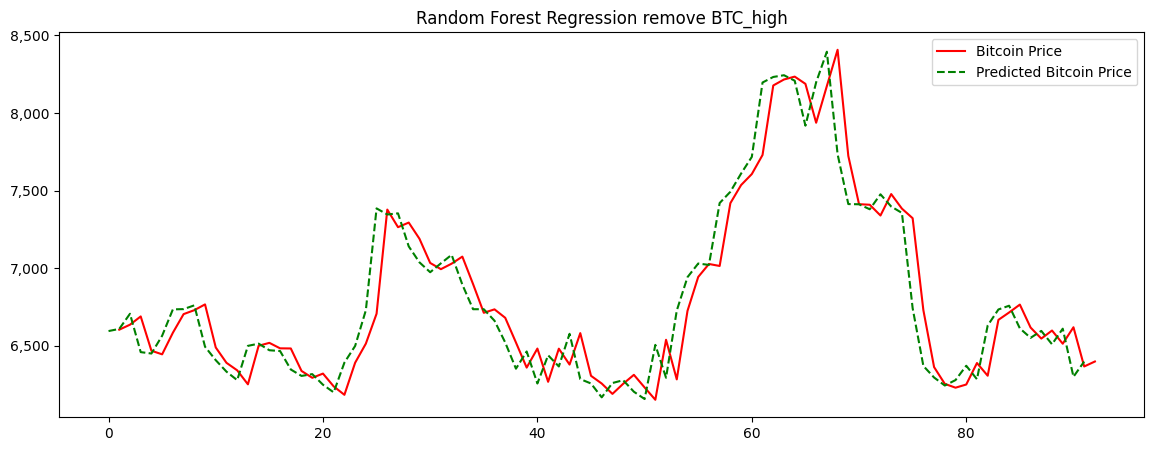

RMSE: 21.772213009456113

MAPE: 0.0023081289674796333

DA accuracy: 100.0%


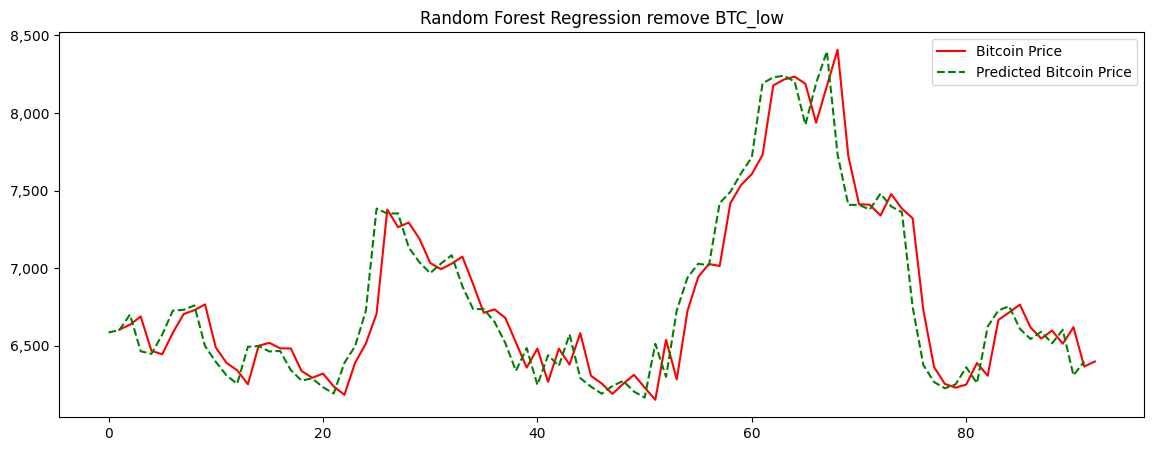

RMSE: 22.495397112502552

MAPE: 0.0023803205299871857

DA accuracy: 96.7%


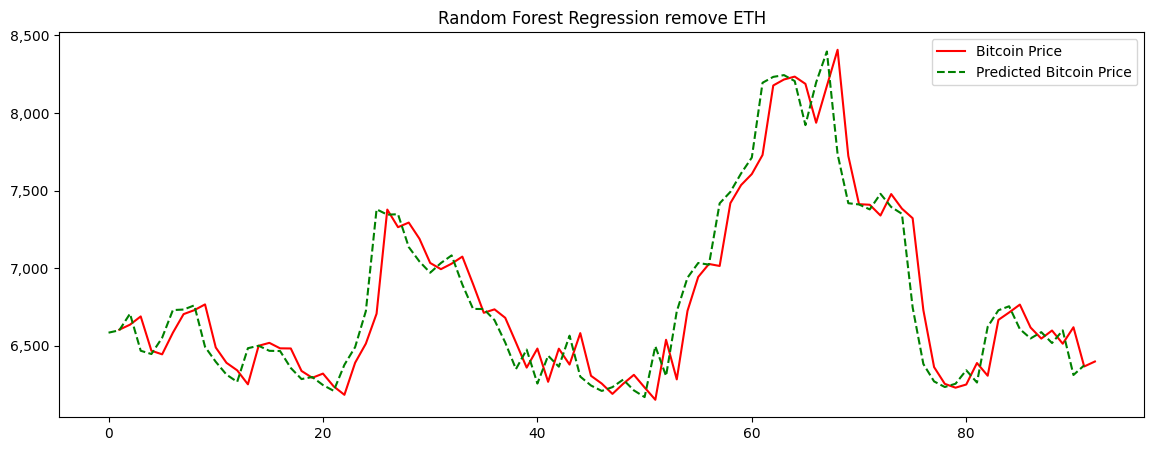

RMSE: 22.92886287491086

MAPE: 0.002601595022679177

DA accuracy: 98.9%


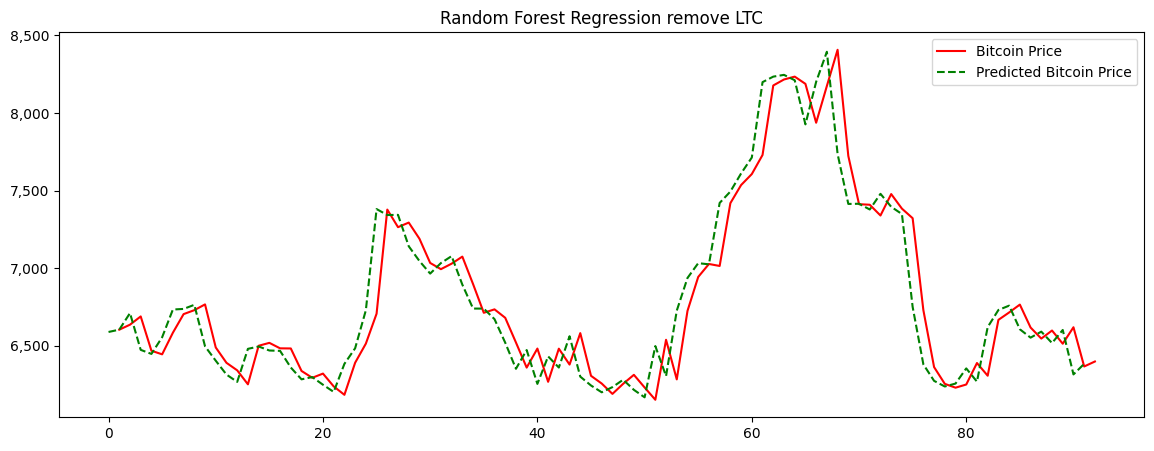

RMSE: 22.537766268268598

MAPE: 0.0026183804546165753

DA accuracy: 97.8%


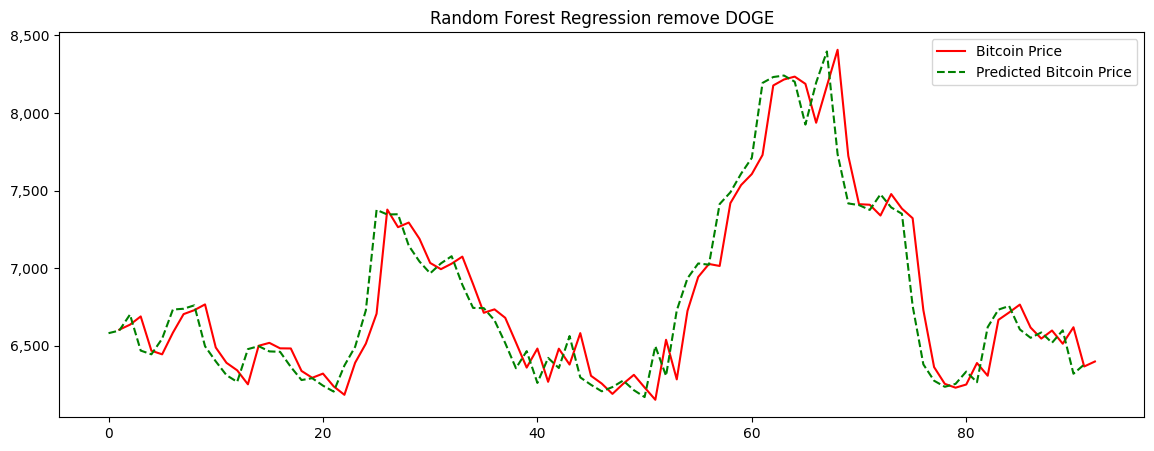

RMSE: 24.094970451013655

MAPE: 0.0027822501534613842

DA accuracy: 96.7%


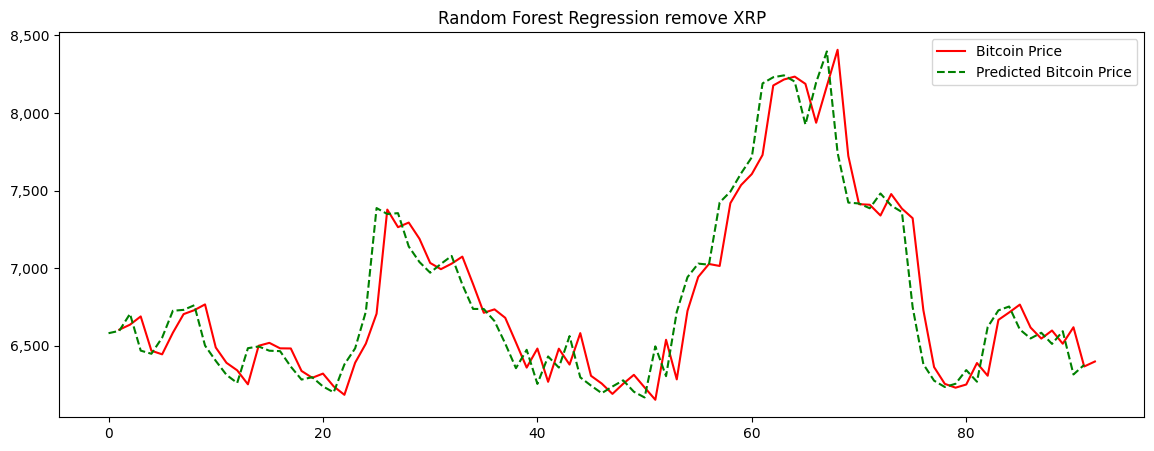

RMSE: 23.95237290977143

MAPE: 0.002717337187640557

DA accuracy: 96.7%


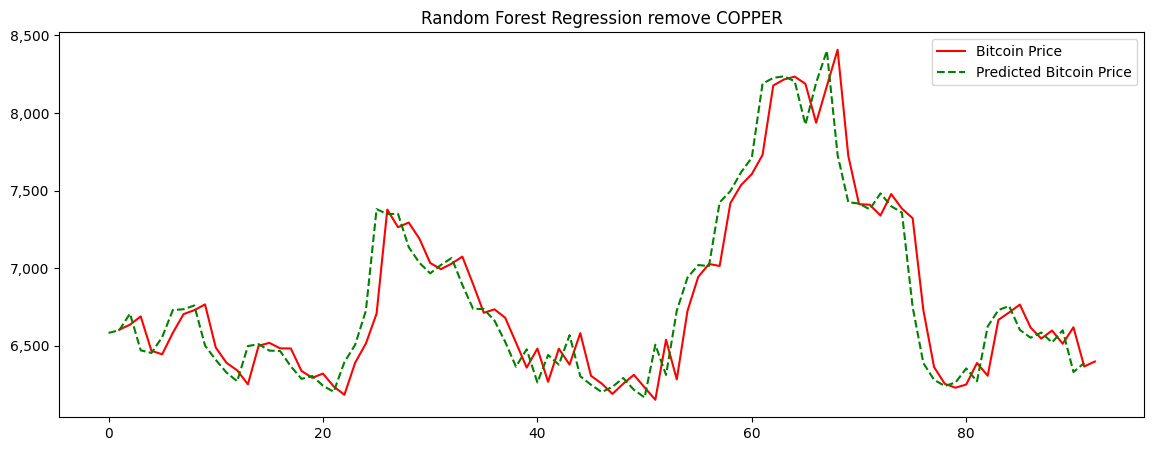

RMSE: 21.651516042340226

MAPE: 0.0024318927283504747

DA accuracy: 97.8%


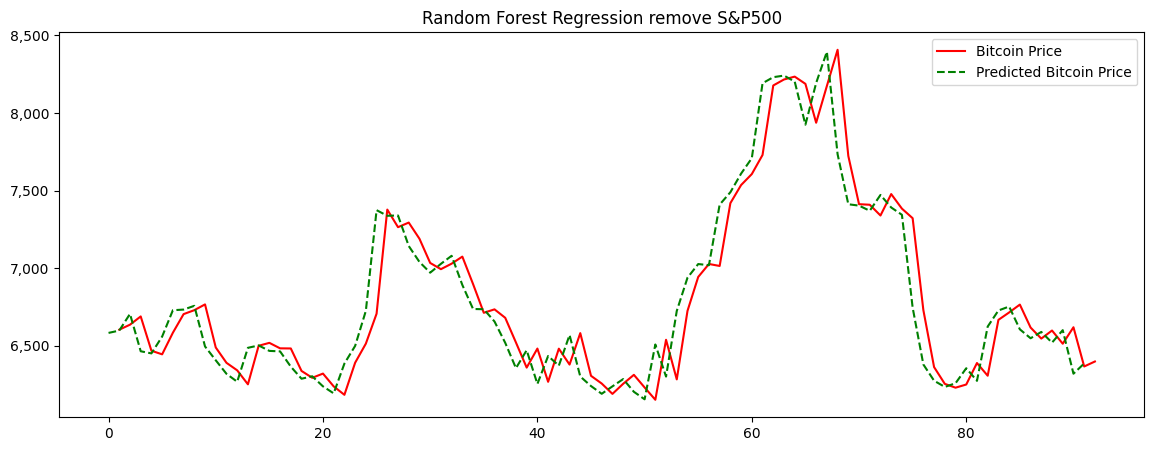

RMSE: 20.61630378543769

MAPE: 0.0023294129734338044

DA accuracy: 98.9%


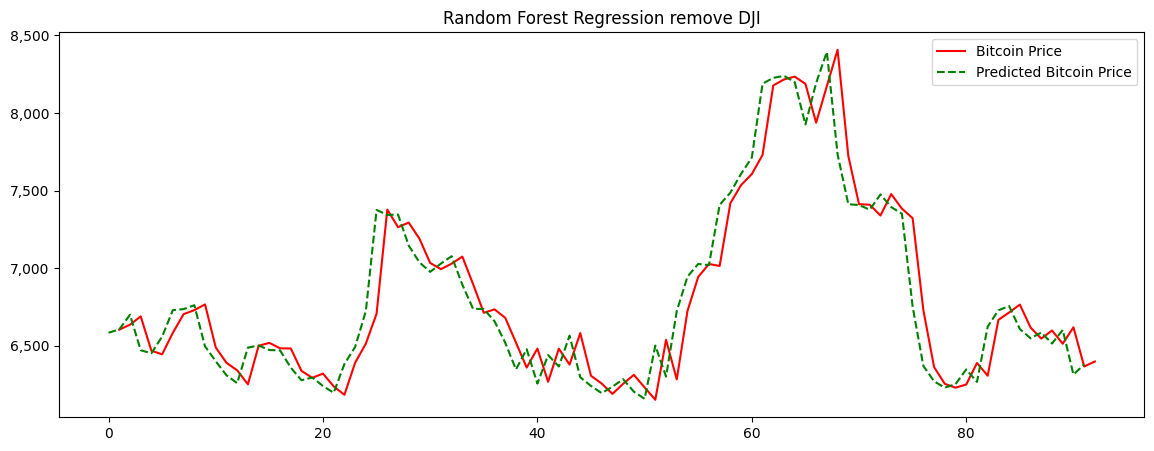

RMSE: 21.39537346522691

MAPE: 0.002346208198172765

DA accuracy: 100.0%


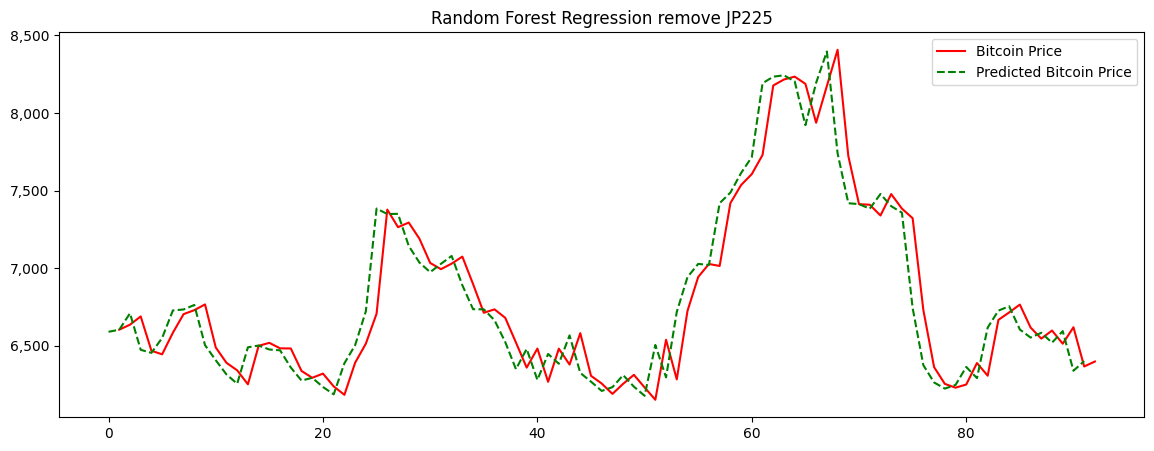

RMSE: 20.85114541142091

MAPE: 0.0022657988965325416

DA accuracy: 96.7%


In [44]:
for columnName in Xtrain:
    columnData = Xtrain[columnName]
    if (columnName == "BTC_close"):
        X_train_re = Xtrain.drop([columnName], axis=1)[:-1]
        Y_train_re = Xtrain["BTC_open"][1:]
        
        X_test_re = Xtest.drop([columnName], axis=1)[:-1]
        Y_test_re = Xtest["BTC_open"][1:]
    else:
        X_train_re = Xtrain.drop([columnName], axis=1)[:-1]
        Y_train_re = Xtrain["BTC_close"][1:]
        
        X_test_re = Xtest.drop([columnName], axis=1)[:-1]
        Y_test_re = Xtest["BTC_close"][1:]
        
    simpleTree = RandomForestRegressor(max_depth=15, n_estimators=500)
    simpleTree.fit(X_train_re, Y_train_re)
    Y_pred_re = simpleTree.predict(X_test_re)
    
    #hien thi ket qua du doan
    fig, ax = plt.subplots(1, 1, figsize=(14, 5))
    ax.plot(Y_test_re, color = 'red', label="Bitcoin Price")
    ax.plot(Y_pred_re, color = 'green', label="Predicted Bitcoin Price", linestyle="dashed")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))  # .3f
    plt.title(f"Random Forest Regression remove {columnName}")
    plt.legend()
    plt.show()
    
    #tinh toan loi du doan
    #RMSE
    from sklearn.metrics import mean_squared_error
    print("RMSE:", np.sqrt(mean_squared_error(Y_test_re, Y_pred_re)))
    print()

    #MAPE
    MAPE_re = np.average(np.abs((Y_test_re.values - Y_pred_re) / Y_test_re.values))
    print("MAPE:", MAPE_re)
    print()

    #DA
    Y_test_DA_re = np.array(Y_test_re)
    Y_pred_0_re = Y_pred_re[1:] - Y_test_DA_re[:-1]
    Y_test_0_re = Y_test_re[1:] - Y_test_DA_re[:-1]
    DA_re = (Y_pred_0_re<0) == (Y_test_0_re<0)
    print("DA accuracy:", f"{round(np.mean(DA_re)*100, 2)}%")
    


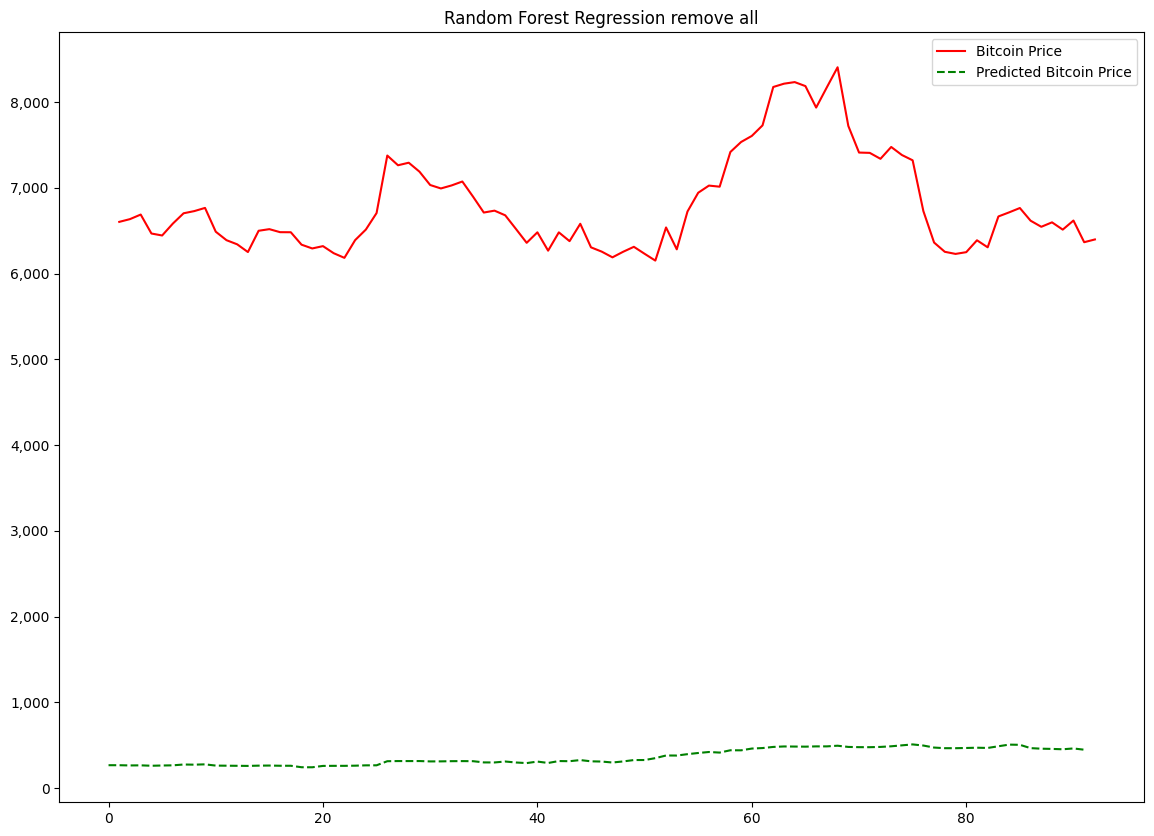

RMSE: 6458.10756854285

MAPE: 0.9466385040649689

DA accuracy: 51.65%


In [48]:
    Xtrainall = train_dataset.loc[:,"BTC_close":"JP225"]
    X_train_all = Xtrainall[:-1]
    Y_train_all = Xtrainall["ETH"][1:]
    
    Xtestall = test_dataset.loc[:,"BTC_close":"JP225"]
    X_test_all = Xtestall[:-1]
    Y_test_all = Xtestall["BTC_close"][1:]

        
    simpleTree = RandomForestRegressor(max_depth=15, n_estimators=500)
    simpleTree.fit(X_train_all, Y_train_all)
    Y_pred_all = simpleTree.predict(X_test_all)
    
    #hien thi ket qua du doan
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    ax.plot(Y_test_all, color = 'red', label="Bitcoin Price")
    ax.plot(Y_pred_all, color = 'green', label="Predicted Bitcoin Price", linestyle="dashed")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))  # .3f
    plt.title(f"Random Forest Regression remove all")
    plt.legend()
    plt.show()
    
    #tinh toan loi du doan
    #RMSE
    from sklearn.metrics import mean_squared_error
    print("RMSE:", np.sqrt(mean_squared_error(Y_test_all, Y_pred_all)))
    print()

    #MAPE
    MAPE_re = np.average(np.abs((Y_test_all.values - Y_pred_all) / Y_test_all.values))
    print("MAPE:", MAPE_re)
    print()

    #DA
    Y_test_DA_re = np.array(Y_test_all)
    Y_pred_0_re = Y_pred_all[1:] - Y_test_DA_re[:-1]
    Y_test_0_re = Y_test_all[1:] - Y_test_DA_re[:-1]
    DA_re = (Y_pred_0_re<0) == (Y_test_0_re<0)
    print("DA accuracy:", f"{round(np.mean(DA_re)*100, 2)}%")